<a href="https://colab.research.google.com/github/Munongedzi/FYP-FACIAL-EMOTION-RECOGNITION-SYSTEM/blob/main/Fernotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd
#import scikitplot
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from multiprocessing import freeze_support
from tf.keras import optimizers
from tf.keras.datasets import mnist
from tf.keras.models import Sequential
from tf.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tf.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tf.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tf.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils 
import os


In [5]:
df = pd.read_csv('/content/drive/MyDrive/fer2013.csv')


In [6]:
df.emotion.unique()
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
INTERESTED_LABELS = [0, 1, 2, 3, 4, 5, 6]
df = df[df.emotion.isin(INTERESTED_LABELS)]
#df.shape
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
img_array.shape
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
#print(le_name_mapping)

X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
shuffle=True, stratify=img_labels,
test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

del df
del img_array
del img_labels

img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]
X_train = X_train / 255.
X_valid = X_valid / 255.

def build_net(optim):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
                        kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
                metrics=['accuracy']
    )
    
    net.summary()
    
    return net
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

checkpoint=ModelCheckpoint("/content/drive/MyDrive/best_model.h5", monitor= 'val_accuracy' , mode = 'max', save_best_only=True )
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
    checkpoint,
]

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

batch_size = 64 #batch size of 32 performs the best.
epochs = 50
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

model = build_net(optims[1]) 
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    )
if __name__ == '__main__':
    freeze_support()
    use_multiprocessing=True


model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save("/content/drive/MyDrive/fer_model.h5")



Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

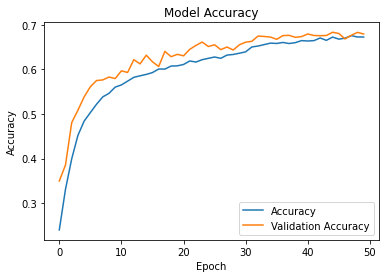

In [8]:
# Show accuracy diagram
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.show()

In [9]:
# Evaluate the model before improvement
_, score_before_improvement = model.evaluate(X_valid, y_valid)
print('Score before improvement: {}'.format(score_before_improvement))

113/113 [==============================] - 1s 10ms/step - loss: 0.9049 - accuracy: 0.6796
Score before improvement: 0.6795764565467834


113/113 [==============================] - 2s 16ms/step


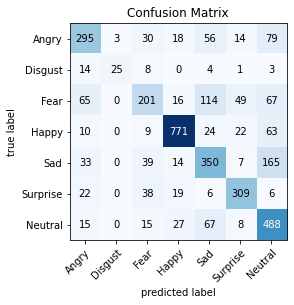

In [15]:
# Make predictions
predictions = model.predict(X_valid)
y_predict = np.argmax(predictions, axis=1)

# Convert y_valid from one-hot encoding to single label format
y_valid_labels = np.argmax(y_valid, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_valid_labels, y_predict)

# Display confusion matrix
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, class_names=class_names)
plt.title('Confusion Matrix')
plt.show()


In [13]:
# Generate hard data
hard_images = []
hard_labels = []

# Make predictions
predictions = model.predict(X_valid)
for i, v in enumerate(predictions):
    y_predict = np.argmax(v)
    y_real = y_train[i]
    if not np.all(y_predict == y_real):
        # If predict incorrectly, append to array
        image = X_valid[i]
        hard_image = image.reshape(1, 48, 48, 1)
        hard_images.append(image)
        hard_labels.append(y_real)

x_hard = np.array(hard_images)
y_hard = np.array(hard_labels)

print(x_hard.shape)
print(y_hard.shape)


113/113 [==============================] - 1s 8ms/step
(3589, 48, 48, 1)
(3589, 7)


# testing with online data

In [18]:
# Download into data folder
import os
os.chdir('/content/drive/MyDrive')

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ommGLsYSnmX8846iyQigKQfIfvpQzsF0' -O happy.jpg > /dev/null 2>&1
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1I1IjDm9Az4pkDqOz3zcQAguEJ1OsWagt' -O sad.jpg > /dev/null 2>&1
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ZLglz_y0QklbYTcwJW1wH0YnAwBn6-1I' -O surprise.jpg > /dev/null 2>&1

In [25]:
from tensorflow.keras.preprocessing import image
categories = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
y_pos = np.arange(len(categories))

INTERESTED_LABELS = [0, 1, 2, 3, 4, 5, 6]
def predict_facial_expression(image_path):
    """Predict facial expression for image"""
    # Open image
    rgb_image = image.load_img(path=image_path,
                            color_mode='grayscale',
                            target_size=(48, 48))
    # Convert to array
    rgb_array = image.img_to_array(rgb_image)
    rgb_array = np.expand_dims(rgb_array, axis=0)

    # Show image
    rgb_display = np.array(rgb_array, 'float32')
    rgb_display = rgb_display.reshape([48, 48]);
    plt.imshow(rgb_display, cmap='gray')
    plt.show()

    # Make predictions
    rgb_array = rgb_array / 255.0
    prediction = model.predict(rgb_array)

    # Draw the histogram
    plt.bar(y_pos, prediction[0], align='center', alpha=0.5)
    plt.xticks(y_pos, categories)
    plt.ylabel('Percentage')
    plt.title('Facial Expression Prediction')
    plt.show()

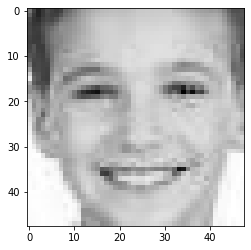

1/1 [==============================] - 0s 41ms/step


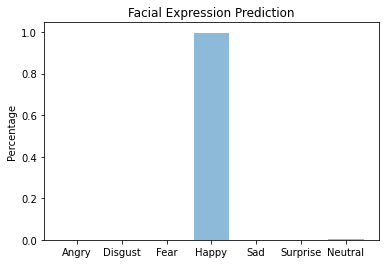

In [26]:
# Happy
predict_facial_expression('happy.jpg')

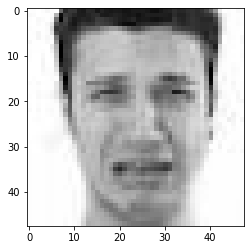

1/1 [==============================] - 0s 33ms/step


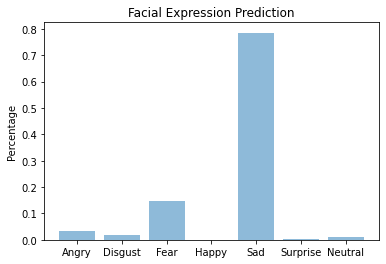

In [27]:
# Sad
predict_facial_expression('sad.jpg')

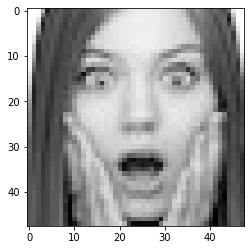

1/1 [==============================] - 0s 22ms/step


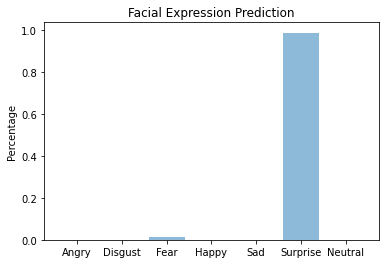

In [28]:
# Surprise
predict_facial_expression('surprise.jpg')

In [31]:
# Save tensorflow lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("/content/drive/MyDrive/FER2013.tflite", "wb").write(tflite_model)

9582760